## 2023F-T3 AISC2007 - Deep Learning 

<hr>

##  Build a GAN model to generated faces using the dataset shared in the ungraded exercise in Week 9

<hr>

### Author
**Fabio Duarte Junior**

### Teacher
**Teacher : Bhavik Gandhi**

### Description
> Use AI generative techniques to create at least 5 images of human faces that do not actually exist
> The professor provided us with a dataset of images of human beings in a variety of positions and scenarios, moods, with one or more faces, complete or partially obscured.

### My approach  

> I got Perplexity.AI and ChatGPT as my co-pilots and also class materials as reference.

> Issues :
>> 1 - Due to my OS behavior, I had to resume the process several times (for instance, when the screensaver starts, my Jupyter notebook kind of "pauses" the processing).
>> For this reason, I could not just run the entire notebook end-to-end in one go.

>> 2 - I made a mistake by not anticipating in my epoch implementations that I would have to resume the process, so the epoch numbers restarted with each resume action, 
>> ending up losing track of the true number of epochs. Fortunately, I saved all epoch metrics, so we can infer that the real number of epochs is the number of rows for the metrics.
 
>> 3 - Please ignore if you see any weird variation in the loss function; I was trying different new approaches.

>> 4 - The pre-processing of the images is not included in this code. I messed up the original pre-processing notebook, as my OpenCV stopped working in my environment and I had to change the approach.

>> But essentially, I used dlib and PIL to read each image in the repository, extract the faces, crop them from the original image, and save them into a new file.

## 00 - Libs

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from IPython.display import Image, display, Markdown
from tqdm import tqdm
import time
from IPython.display import clear_output
import ipywidgets as widgets
import math
from IPython.display import Image

## 01 - Data And Conguration

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
data_root  = 'test7-small'
img_size=64

In [3]:
## Reverse Nomalization
def scale_image(img):
    return (img+1)/2

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
    ,transforms.Normalize(mean=(0.5), std=(0.5))
])
train_dataset    = datasets.ImageFolder(root=data_root, transform=transform)


In [5]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(dataset    = train_dataset,                                        
                                          batch_size = batch_size,
                                          shuffle    = True)

## 02 - Discriminator and Generator Architectures

In [6]:
## Discriminator
D = nn.Sequential(
        nn.Linear(img_size*img_size*3,512),nn.LeakyReLU(0.2),
        nn.Linear(512,256),nn.LeakyReLU(0.2),
        nn.Linear(256,1)
        #,nn.Sigmoid()
                 )
D = D.to(device)

## Latent Dimension
latent_dim = 100

## Generator
G = nn.Sequential(
    nn.Linear(latent_dim,256) ,nn.LeakyReLU(0.2),nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256,512)        ,nn.LeakyReLU(0.2),nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512,1024)       ,nn.LeakyReLU(0.2),nn.BatchNorm1d(1024,momentum=0.7),
    nn.Linear(1024,img_size*img_size*3)       ,nn.Tanh()
                 )
G = G.to(device)

## 03 - Optimizer

In [7]:
## Loss
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002,betas=(0.5,0.999))

In [8]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')


In [9]:
d_losses = list()
g_losses = list()
D_AVGLoss_list = list()
G_AVGLoss_list = list()

## 04 - Auxiliar functions¶

In [10]:
def generate_images(model, num_images=1, latent_dim=100,epoch_n=0,amount=4):
    noise = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        generated_images = model(noise).detach().cpu()

    num_rows = math.ceil(num_images / amount)
    num_cols = min(num_images, amount)   
    plt.figure(figsize=(8, 2 * num_rows))  

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1) 
        plt.imshow((generated_images[i].numpy().transpose(1, 2, 0) * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)   
    plt.show()    
    plt.savefig('gan_images/dcgan_'+str(epoch_n), bbox_inches='tight', pad_inches=0.0)
    plt.close() 

## 05 - Training function

In [11]:
# Create list with zeros and ones for using it as labels
ones_ = torch.ones(batch_size,1).to(device)
zero_ = torch.zeros(batch_size,1).to(device)



# Store the losses


## To help in the display organization
def clear_cell_output():
    clear_output(wait=True)

def run_epocs(num_epochs):

    for epoch in range(num_epochs):
        sum_D_loss =0
        sum_G_loss =0
        start_time        = time.time()  
        for inputs,_ in tqdm(data_loader):
            n = inputs.size(0)
            inputs = inputs.reshape(n, img_size*img_size*3).to(device)
    
            ones = ones_[:n]
            zeros = zero_[:n]
    
            # Training discriminator
            
            real_outputs = D(inputs)
            d_loss_real  = criterion(real_outputs, ones)
    
            noise = torch.randn(n,latent_dim).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)
            d_loss_fake = criterion(fake_outputs, zeros)
    
            ## Gradient descent setp
            d_loss = 0.5 *(d_loss_real + d_loss_fake)
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
    
            # Training generator
            for _ in range(2):
                noise        = torch.randn(n,latent_dim).to(device)
                fake_images  = G(noise)
                fake_outputs = D(fake_images)
    
                g_loss = criterion(fake_outputs, ones)
    
                d_optimizer.zero_grad()
                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()
                
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            sum_D_loss += d_loss.item()
            sum_G_loss += g_loss.item()
            
        ## Variables for display metrics
        average_D_loss = sum_D_loss / len(data_loader.dataset)
        average_L_loss = sum_G_loss / len(data_loader.dataset)
        D_AVGLoss_list.append(average_D_loss)
        G_AVGLoss_list.append(average_L_loss)
        end_time        = time.time()  
        elapsed_time    = end_time - start_time 
    
        clear_cell_output ()    
        markdown_table  = "| Epoch | Discriminator AVG Loss | Generator AVG Loss | Time |\n"
        markdown_table += "|-------|------------------------|--------------------|------|\n"
        markdown_table += f"| {epoch} /{num_epochs}| **{d_loss.item():.8f}** |**{g_loss.item():.8f}** | {elapsed_time:.4f} seconds |"
    
      
        display(Markdown(markdown_table))
        fake_images = fake_images.reshape(-1,3,64,64)
        save_image(scale_image(fake_images), "gan_images/test.png",nrow=9)
        #save_image(fake_images, "gan_images/test.png",nrow=9)
    
        ## Just a bunch of code for making a good presentation of the epochs =]
        file_path = "gan_images/test.png" 
        image_widget = widgets.Image(
            value=open(file_path, "rb").read(),
            format='png',
            width=600,  
            height=600,  
        )    
        plot_widget = widgets.Output()    
    
       ## Same here
        with plot_widget:
            plt.figure(figsize=(8, 2))  
            plt.plot(g_losses, label='Generator')
            plt.plot(d_losses, label='Discriminator')
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Loss Variation Through Training iterations')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(G_AVGLoss_list)
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('Generator')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(D_AVGLoss_list)
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('Discriminator')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(G_AVGLoss_list, label='Generator')
            plt.plot(D_AVGLoss_list, label='Discriminator')
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('AVG Loss through Epocs')
            plt.show()            
           
        horizontal_layout = widgets.HBox([image_widget, plot_widget])
      

        display(Image(filename="gan_images/test.png" ))
        #display(horizontal_layout)

| Epoch | Discriminator AVG Loss | Generator AVG Loss | Time |
|-------|------------------------|--------------------|------|
| 3237 /5000| **0.08225267** |**10.19566917** | 1.2336 seconds |

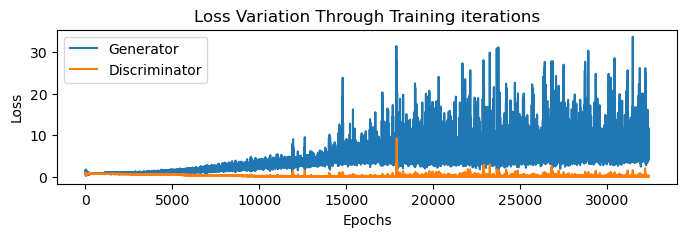

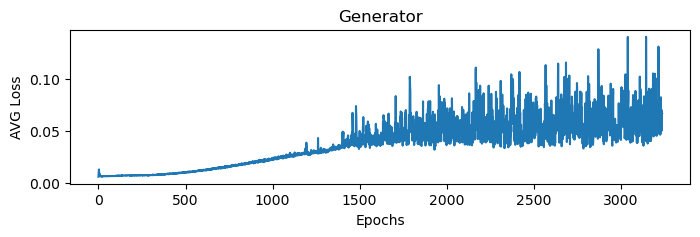

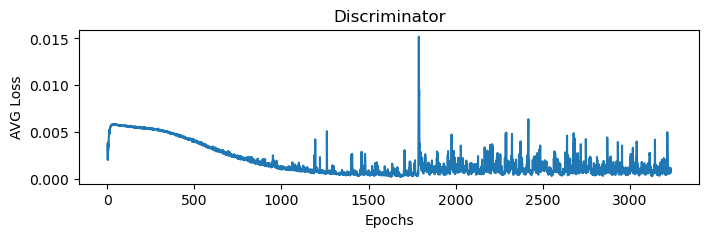

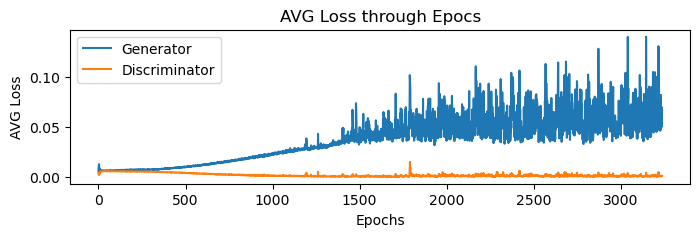

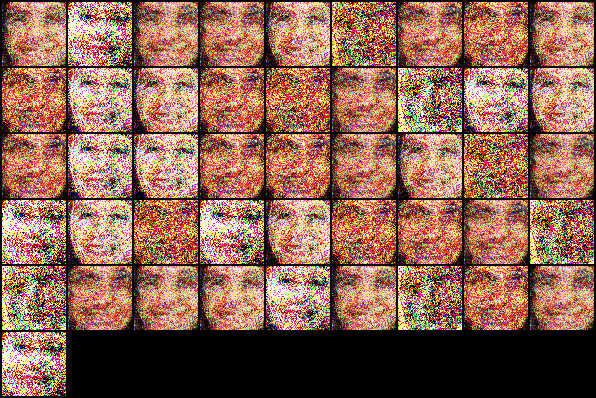

 20%|██        | 2/10 [00:00<00:01,  6.23it/s]


KeyboardInterrupt: 

In [12]:
## Dataset test7
run_epocs(5000)

##  06 - Final result

In [ ]:
from IPython.display import Image

Image(filename="gan_images/test.png" )

In [ ]:
plt.figure(figsize=(8, 2))  
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation Through Training iterations')
plt.show()

plt.figure(figsize=(8, 2))  
plt.plot(G_AVGLoss_list)
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('Generator')
plt.show()

plt.figure(figsize=(8, 2))  
plt.plot(D_AVGLoss_list)
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('Discriminator')
plt.show()

plt.figure(figsize=(8, 2))  
plt.plot(G_AVGLoss_list, label='Generator')
plt.plot(D_AVGLoss_list, label='Discriminator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('AVG Loss through Epocs')
plt.show()